In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [61]:
train = pd.read_csv("train_v9rqX0R.csv")
test = pd.read_csv("test_AbJTz2l.csv")

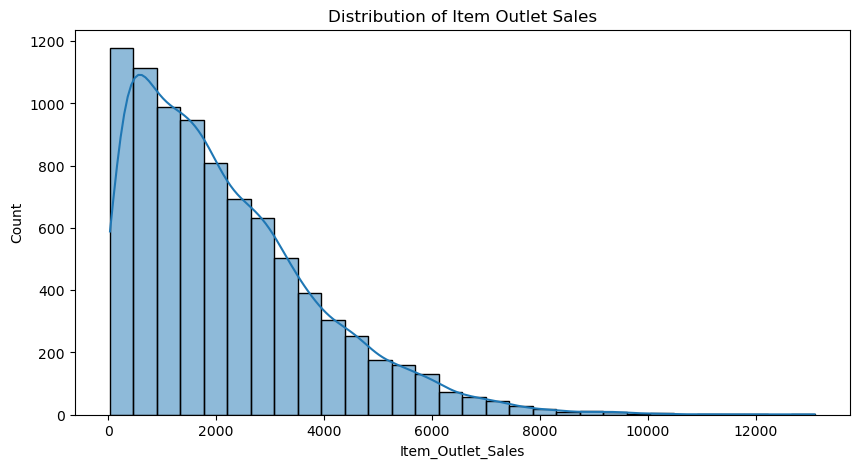

In [62]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 5))
sns.histplot(train['Item_Outlet_Sales'], bins=30, kde=True)
plt.title('Distribution of Item Outlet Sales')
plt.show()


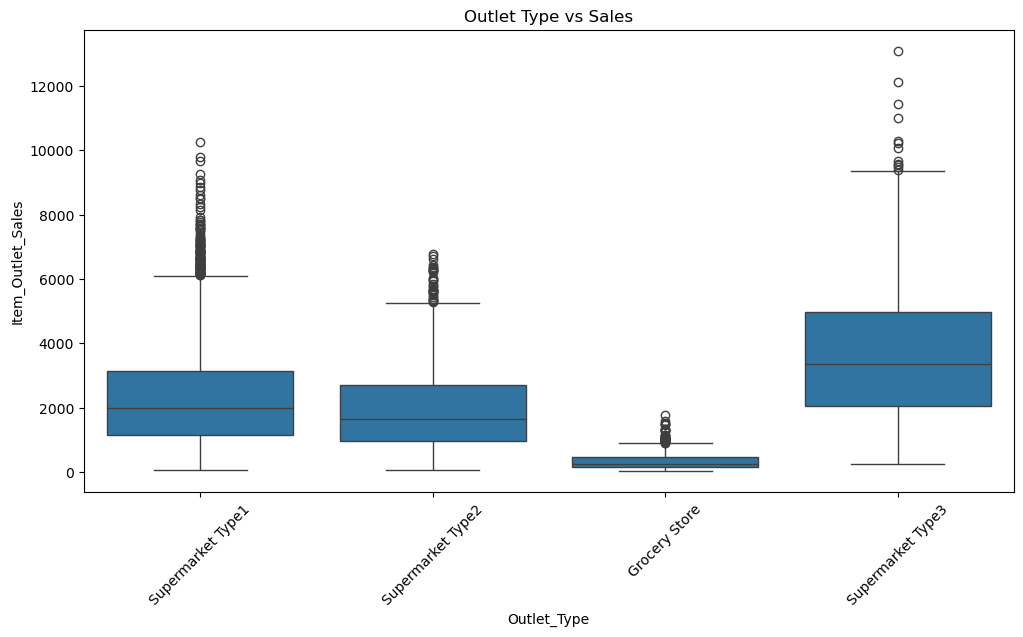

In [63]:

plt.figure(figsize=(12, 6))
sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales', data=train)
plt.xticks(rotation=45)
plt.title('Outlet Type vs Sales')
plt.show()



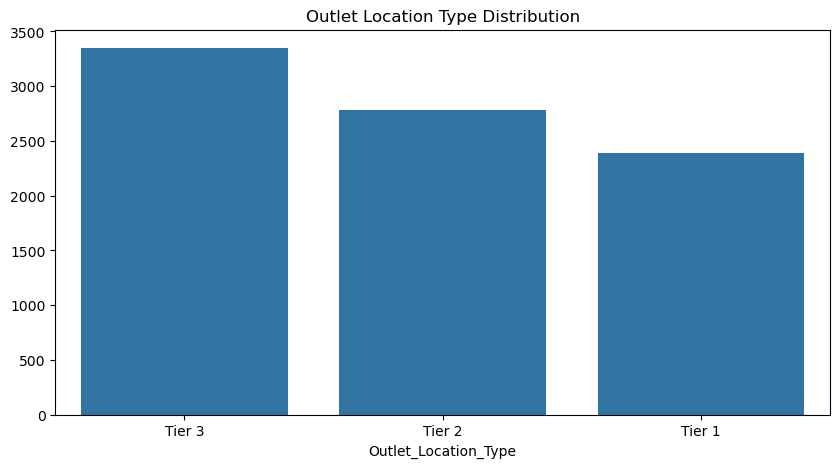

In [64]:
plt.figure(figsize=(10, 5))
sns.barplot(x=train['Outlet_Location_Type'].value_counts().index, y=train['Outlet_Location_Type'].value_counts().values)
plt.title('Outlet Location Type Distribution')
plt.show()

In [65]:
# Fill missing values
imputer = SimpleImputer(strategy='mean')
train['Item_Weight'] = imputer.fit_transform(train[['Item_Weight']])
test['Item_Weight'] = imputer.transform(test[['Item_Weight']])

train['Outlet_Size'].fillna(train['Outlet_Size'].mode()[0], inplace=True)
test['Outlet_Size'].fillna(test['Outlet_Size'].mode()[0], inplace=True)


C:\Users\ashwa\AppData\Local\Temp\ipykernel_6944\3444785184.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Outlet_Size'].fillna(train['Outlet_Size'].mode()[0], inplace=True)
C:\Users\ashwa\AppData\Local\Temp\ipykernel_6944\3444785184.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

In [66]:
# Preserve identifier columns for submission
item_identifiers = test['Item_Identifier']
outlet_identifiers = test['Outlet_Identifier']

In [67]:
# Drop identifier columns
train.drop(columns=['Item_Identifier'], inplace=True)
test.drop(columns=['Item_Identifier'], inplace=True)

In [68]:
# One-Hot Encoding for categorical features
categorical_features = ['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type', 'Outlet_Size', 'Outlet_Identifier']
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

ohe_train = pd.DataFrame(encoder.fit_transform(train[categorical_features]))
ohe_test = pd.DataFrame(encoder.transform(test[categorical_features]))


In [69]:
# Reset index after encoding
ohe_train.index = train.index
ohe_test.index = test.index

In [70]:
# Drop original categorical columns and merge encoded data
train = train.drop(columns=categorical_features).join(ohe_train)
test = test.drop(columns=categorical_features).join(ohe_test)

In [71]:
# Ensure all feature names are strings
train.columns = train.columns.astype(str)
test.columns = test.columns.astype(str)

In [72]:
# Feature Selection
X = train.drop(columns=['Item_Outlet_Sales'])
y = train['Item_Outlet_Sales']

In [73]:
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [74]:
# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_valid)
lr_rmse = np.sqrt(mean_squared_error(y_valid, lr_preds))
print(f'Linear Regression RMSE: {lr_rmse}')

Linear Regression RMSE: 1069.5153692788904


In [75]:
# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_valid)
rf_rmse = np.sqrt(mean_squared_error(y_valid, rf_preds))
print(f'Random Forest RMSE: {rf_rmse}')


Random Forest RMSE: 1090.8138328642026


In [76]:
# Make Final Predictions on Test Data
final_preds = rf_model.predict(test)

In [77]:
# Save Predictions
submission = pd.DataFrame({'Item_Identifier': item_identifiers, 'Outlet_Identifier': outlet_identifiers, 'Item_Outlet_Sales': final_preds})
#submission.to_csv('submission.csv', index=False)